<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 50px"> 

#   Project 4: Detecting Hate Speech

> SG-DSI-41 Group 01: Lionel Foo, Joel Lim, Poon Wenzhe, Daryl Chia

---

#### <b> Notebook: 02A-M1 Classification Model (Multiclass Classification - RNN w/out GloVe Word Embeddings) </b>

<b>Notebook Outline</b>

1. Import Libraries, Data & Specify Random Seeds
2. Load & Check Data
3. Additional Pre-Processing for Modeling
4. Prepare Data for Modelling
5. Train Classification Model
6. Evaluate Classification Model


---

<b> 1. Import Libraries, Data & Specify Random Seeds </b>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report

# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 4000

In [30]:
# Set the seed for numpy and tensorflow to ensure reproducibility across runs.
np.random.seed(42)
tf.random.set_seed(42)


---

<b> 2. Load & Check Data </b>

In [31]:
# Load data:
df = pd.read_csv("data/hate-speech-and-offensive-language-dataset_cleaned.csv")

# Check data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24773 entries, 0 to 24772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24773 non-null  int64 
 1   tweet   24773 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.2+ KB


In [32]:
# Check tweet' column for missing values
df[df['tweet'].isna()]

,class,tweet


In [33]:
df.head()

,class,tweet
0,2,as a woman you should not complain about cleaning up your house as a man you should always take the trash out
1,1,boy dats cold tyga dwn bad for cuffin dat hoe in the st place
2,1,dawg you ever fuck a bitch and she start to cry you be confused as shit
3,1,she look like a tranny
4,1,the shit you hear about me might be true or it might be faker than the bitch who told it to ya


In [34]:
# Check for the distribution of Class
df['class'].value_counts()

class
1    19187
2     4158
0     1428
Name: count, dtype: int64


---

<b> 3. Additional Pre-Processing for Modeling </b>

Outline
* (a) **Create a List of Stop Words to Remove**: Stop words are common words that do not contribute much to the model's understanding of the text. We'll create a list of these to remove from our data.
* (b) **Identify Redundant Words**: We'll check the top 200 1-gram, 2-gram, and 3-gram words for any redundant terms. If we find any, we'll add them to our stop words list.
* (c) **Repeat Steps (a) and (b)**: We'll repeat the process of identifying and removing stop words until we're satisfied with our list.
* (d) **Remove Single-Character Words**: Words with a length of 1 are often not useful for our model, so we'll remove these.
* (e) **Remove Stopwords and Lemmatize**: Finally, we'll remove the stop words we identified and lemmatize the remaining words. Lemmatization is the process of reducing words to their base or root form.

<b> (a) Create a List of Stop Words to Remove </b>

In [35]:
# additional stop words to remove
additional_stop_words = ['amp', 'wa', 'ai', 'na', 'ca', 'ya', 'im', 'gon',
                          'll', 'ha', 'wan', 'ta', 'da', 'gt', 'doe', 'ur', 'tho', 've',
                            'em', 'wo', 'lt', 'got', 'charlie', 'crist', 'wit', 'yo',
                              'tf', 'la', 'sta', 'pa' , 'hea']

# Combine native 'english' stop words with additional stop words
all_stop_words = list(set(ENGLISH_STOP_WORDS).union(additional_stop_words))

<b> (b) Identify Redundant Words </b>

In [36]:
# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization and get top N n-grams
def get_top_ngrams_lemmatized(df, n=200, ngram_range=(1, 1)):
    # Tokenize and lemmatize the text
    lemmatized_text = df['tweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower())]))
    
    # Instantiate a CountVectorizer object with specified ngram_range
    vectorizer = CountVectorizer(stop_words=all_stop_words, ngram_range=ngram_range)
    
    # Fit and transform the count vectorizer on the lemmatized body text
    X = vectorizer.fit_transform(lemmatized_text)
    
    # Convert to a dataframe and densify
    ngram_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())
    
    # Sum the n-gram occurrences and sort by frequency
    ngram_counts = ngram_df.sum().sort_values(ascending=False)
    
    # Get the top N n-grams
    top_ngrams = ngram_counts.head(n)
    
    return top_ngrams

<b> (c) Display top 200 1-gram words </b>

In [37]:
# Display all rows:
pd.set_option('display.max_rows', None)

# Get top 200 lemmatized 1grams
top_onegram = get_top_ngrams_lemmatized(df, n=200, ngram_range=(1, 1))

# Display the results
print("\nTop 200 Lemmatized Onegrams:")
print(top_onegram)


Top 200 Lemmatized Onegrams:
bitch        11440
hoe           4338
like          2835
pussy         2249
nigga         2016
just          1470
fuck          1457
shit          1297
trash         1161
lol           1099
want          1002
know           932
love           754
girl           699
going          637
fucking        630
make           601
bird           601
look           586
say            577
bad            569
man            567
good           535
need           531
faggot         528
think          499
time           496
people         487
hate           486
let            469
day            458
really         424
did            424
right          421
real           413
white          388
lmao           383
said           381
come           371
dick           357
tell           340
life           339
bout           335
stop           333
talk           331
nigger         325
damn           324
little         323
dat            316
cunt           297
new            296
f

<b> (c) Display top 200 2-gram words </b>

In [38]:
# Get top 200 lemmatized bigrams
top_bigram = get_top_ngrams_lemmatized(df, n=200, ngram_range=(2, 2))

# Display the results
print("\nTop 200 Lemmatized Bigrams:")
print(top_bigram)


Top 200 Lemmatized Bigrams:
bad bitch           335
like bitch          286
look like           269
bitch nigga         241
fuck bitch          231
bitch like          218
nigga bitch         143
little bitch        141
bitch want          130
bitch just          117
bitch bitch         115
dumb bitch          113
bitch know          112
lil bitch           107
bitch lol           104
eat pussy           103
white trash         101
bitch love           99
bitch fuck           94
fat bitch            87
act like             86
like hoe             86
hate bitch           86
feel like            84
hoe hoe              83
hoe loyal            80
bitch shit           77
just like            73
bitch need           72
stupid bitch         71
shit bitch           69
dat bitch            69
just want            68
hoe nigga            68
fuck hoe             66
hoe like             66
bitch look           65
know bitch           65
ugly bitch           65
fucking bitch        64
pussy like 

<b> (c) Display top 200 3-gram words </b>

In [39]:
# Get top 200 lemmatized trigrams
top_trigram = get_top_ngrams_lemmatized(df, n=200, ngram_range=(3, 3))

# Display the results
print("\nTop 200 Lemmatized Trigrams:")
print(top_trigram)


Top 200 Lemmatized Trigrams:
bitch look like               41
fuck right pussy              25
bitch thing like              24
bad bitch thing               22
park slope rated              19
slope rated spa               19
like little bitch             19
best asian massage            19
pussy taste like              18
big booty hoe                 18
bitch bitch bitch             16
pussy smell like              16
act like bitch                15
big booty bitch               15
look like bitch               15
massage park slope            14
fuck nigga bitch              14
asian massage park            14
cunt cunt cunt                13
like bad bitch                13
nigga talk bitch              13
type bad bitch                13
talk bitch day                12
lil stupid bitch              11
bitch suck dick               11
bitch talk shit               11
worried bout bitch            11
early bird worm               11
fuck bitch money              10
man trash man

<b> (d) Remove Single-Word Characters </b>

In [40]:
# Def function to remove terms with a length of 1
def remove_single_char_terms(text):
    # Remove terms with a length of 1
    return ' '.join([word for word in text.split() if len(word) > 1])

In [41]:
# Apply the function to the 'tweet'column
df['tweet'] = df['tweet'].apply(remove_single_char_terms)

<b> (e) Remove Stop Words and Lemmatize </b>

In [42]:
def remove_stopwords(text):
    # Initialize an empty list to store important words
    imp_words = []

    # Iterate through each word in the input text
    for word in str(text).split():
        # Check if the word is not in the list of stop words
        if word not in all_stop_words:
            
            # Lemmatize the word before appending to the imp_words list
            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)
            
            # Append the lemmatized word to the imp_words list
            imp_words.append(word)

    # Join the important words into a single string
    output = " ".join(imp_words)

    return output

# Apply the remove_stopwords function to the 'tweet' column of the dataframe
df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))

# Display the first 30 rows of the dataframe after removing stopwords
df.head(30)

,class,tweet
0,2,woman complain cleaning house man trash
1,1,boy dats cold tyga dwn bad cuffin dat hoe st place
2,1,dawg fuck bitch start confused shit
3,1,look like tranny
4,1,shit hear true faker bitch told
5,1,shit just blows claim faithful somebody fucking hoes
6,1,just sit hate bitch shit going
7,1,tired big bitches coming skinny girls
8,1,bitch
9,1,hobbies include fighting mariam bitch



---

<b> 4. Prepare Data for Modelling </b>

Outline
* (a) Evaluate Class Imbalance
* (b) Perform Train-Test-Split
* (c) Address Class Imbalance
* (d) Tokenise & Pad Text Sequences

<b> (a) Evaluate Class Imbalance </b>

In [43]:
# 1. Create X (teatures) and y (target)
X = df['tweet']
y = df['class']

In [44]:
# 2. Evaluate class imbalance
print("== Examine Class Imbalance ==", "\n")

print("= Counts =", "\n")
print(y.value_counts(), "\n")

print("= Proportions =", "\n")
print(y.value_counts(normalize = True))

== Examine Class Imbalance == 

= Counts = 

class
1    19187
2     4158
0     1428
Name: count, dtype: int64 

= Proportions = 

class
1    0.774513
2    0.167844
0    0.057643
Name: proportion, dtype: float64


Comments: Class Imbalance
* Class [0]: Hate Speech ; Class [1]: Offensive Language, Class [2]: Neither
* There are a disproportionately low number of "hate speech" (5.8%) and "neither" (16.8%) tweets

Comments: Approach to Addressing Class Imbalance
* Undersampling (oversampling) of the most (least) numerous class to attain a tweet count equivalent to the "neither" class (as it has a tweet count between both classes), where we'll:
    * undersample: the most numerous class ("offensive language") 
    * oversample: the least numerous class ("hate speech)

* To prevent "training" data from leaking into the "testing" data - the class rebalancing procedure will be applied:
    * after the "train-test-split" step, and
    * applied to the "training" sample only

<b> (b) Perform Train-Test-Split </b>

In [45]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<br>
<b> (c) Address Class Imbalance </b>

Recall Approach: Rebalance Classes within the "Training" Sample Only

* Undersampling (oversampling) of the most (least) numerous class to attain a tweet count equivalent to the "neither" class (as it has a tweet count between both classes), where we'll:
    * undersample: the most numerous class ("offensive language") 
    * oversample: the least numerous class ("hate speech)

In [46]:
# Perform Class Rebalancing on "Training" Data

# 1. Temporarily Concatenate X_train and y_train (Column-to-Column)
df_train = pd.concat(objs=[X_train,y_train], axis=1)

# 2. Perform Rebalancing
class_2 = df_train[df_train["class"] == 2]
class_1 = df_train[df_train["class"] == 1].sample(n=3350, random_state=42)
class_0 = df_train[df_train["class"] == 0]

df_train_balanced = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

# 3. Check For Class Balance
print("== Examine Class Balance : Proportions ==", "\n")
print(df_train_balanced["class"].value_counts(normalize=True))

== Examine Class Balance : Proportions == 

class
0    0.339337
1    0.331519
2    0.329144
Name: proportion, dtype: float64


In [47]:
# Perform Class Rebalancing on "Training" Data (Cont'd)

# 4. Add balanced: X_train_bal, y_train_bal
X_train_bal = df_train_balanced["tweet"]
y_train_bal = df_train_balanced["class"]

# 5. Check that X_train_bal "tweets" are treated as strings
print("X_train_bal data type:", X_train_bal.dtype)

X_train_bal data type: object


In [48]:
# Dummify "training" and "testing" data's target
# > as we have multiple class categories

y_train_bal_i = y_train_bal.copy()
y_test_i = y_test.copy()

y_train_bal = pd.get_dummies(y_train_bal)
y_test      = pd.get_dummies(y_test)

print("Shape y_train_bal:", y_train_bal.shape)
print("Shape y_test:", y_test.shape)

Shape y_train_bal: (10105, 3)
Shape y_test: (4955, 3)


<br>
<b> (d) Tokenise & Pad Text Sequences </b>

In [49]:
# Perform Tokenisation

# 1. Initialize Tokenizer and fit on X_train_resampled
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_bal)

# 2. Use that tokenizer to transform (convert) the text message strings in training and test data into a list of integers where each integer represents the index of that word
X_train_bal_seq = tokenizer.texts_to_sequences(X_train_bal)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [50]:
# Pad Text Sequences

# 1. Obtain maximum length of text sequences in X_train and X_test
max_len_train = max(len(seq) for seq in tokenizer.texts_to_sequences(X_train_bal))
max_len_test  = max(len(seq) for seq in tokenizer.texts_to_sequences(X_test))
max_len = max(max_len_train, max_len_test)

print("Max sequence length:", max_len)

# 2. Pad Text Sequences
X_train_bal_seq_padded = pad_sequences(X_train_bal_seq, max_len)
X_test_seq_padded = pad_sequences(X_test_seq, max_len)

# 3. Preview padded text sequence
print("Preview padded text sequence:")
X_test_seq_padded[0]

Max sequence length: 25
Preview padded text sequence:


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0, 1353,  113,
        255,  299,   12])


---

<b> 5. Train Classification Model </b>

1. Define Model
2. Define callbacks
3. Fit the RNN model

In [51]:
# 1. Define a RNN-LSTM model architecture using Keras
model = keras.models.Sequential([

    layers.Embedding(max_words, 64, input_length=max_len),

    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])
# Configure the model with Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
 
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            640000    
                                                                 
 bidirectional (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 

In [52]:
# 2. Define callbacks

# EarlyStopping callback to stop training if 'val_accuracy' doesn't improve for 10 consecutive epochs,
# Restoring the weights of the epoch with the best validation accuracy.
es = EarlyStopping(patience=10,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
                   
# Reduce learning rate by a factor of 0.5 if 'val_loss' doesn't improve for 5 consecutive epochs.  
lr = ReduceLROnPlateau(patience = 5,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [53]:
# 3. Fit the RNN model
history = model.fit(X_train_bal_seq_padded, y_train_bal,
                    validation_data=(X_test_seq_padded, y_test),
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])

Epoch 1/50




316/316 [==============================] - 22s 40ms/step - loss: 1.7245 - accuracy: 0.6198 - val_loss: 1.6134 - val_accuracy: 0.5728 - lr: 1.0000e-04
Epoch 2/50
316/316 [==============================] - 11s 34ms/step - loss: 0.9213 - accuracy: 0.8381 - val_loss: 0.8908 - val_accuracy: 0.8089 - lr: 1.0000e-04
Epoch 3/50
316/316 [==============================] - 11s 35ms/step - loss: 0.5537 - accuracy: 0.9069 - val_loss: 0.6586 - val_accuracy: 0.8367 - lr: 1.0000e-04
Epoch 4/50
316/316 [==============================] - 11s 34ms/step - loss: 0.3662 - accuracy: 0.9396 - val_loss: 0.5836 - val_accuracy: 0.8595 - lr: 1.0000e-04
Epoch 5/50
316/316 [==============================] - 11s 34ms/step - loss: 0.2673 - accuracy: 0.9549 - val_loss: 0.8047 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 6/50
316/316 [==============================] - 11s 35ms/step - loss: 0.2040 - accuracy: 0.9630 - val_loss: 0.6907 - val_accuracy: 0.8141 - lr: 1.0000e-04
Epoch 7/50
316/316 [=========================


---

<b> 6. Evaluate Classification Model </b>

(a) Evaluate loss and accuracy epoch-by-epoch

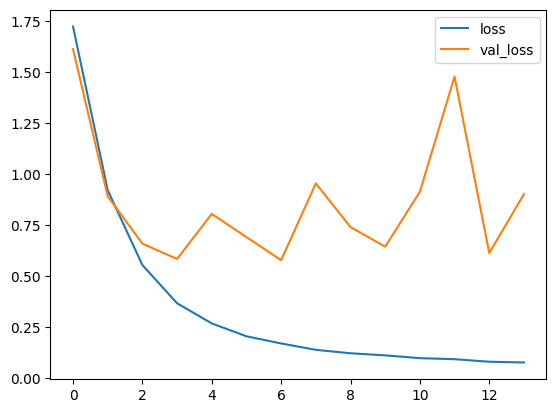

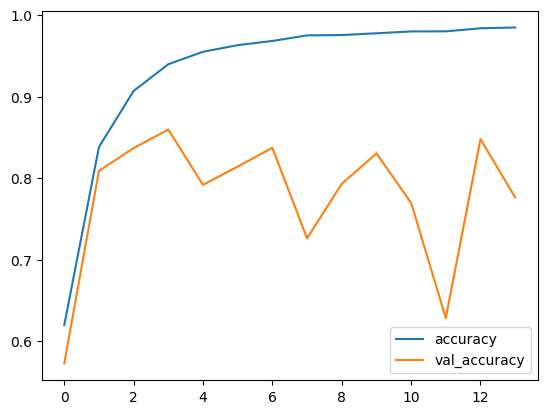

In [54]:
# Graph: loss and accuracy epoch-by-epoch
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [55]:
# Table: loss and accuracy epoch-by-epoch
history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,1.724491,0.619792,1.613435,0.572755,0.00010
1,0.921312,0.838100,0.890845,0.808880,0.00010
2,0.553744,0.906878,0.658607,0.836731,0.00010
3,0.366245,0.939634,0.583619,0.859536,0.00010
4,0.267301,0.954874,0.804665,0.791726,0.00010
5,0.204044,0.962989,0.690738,0.814127,0.00010
6,0.168978,0.968135,0.577594,0.837134,0.00010
7,0.137668,0.974963,0.954460,0.726135,0.00010
8,0.120828,0.975359,0.739833,0.792936,0.00010
9,0.110488,0.977536,0.643915,0.830272,0.00010


In [56]:
# Identify best epoch
best_epoch = np.argmax(history.history['val_accuracy']) + 1
print("Best epoch: ", best_epoch)

Best epoch:  4


(b) Obtain model evaluation metrics

In [57]:
# Define function: generate predicted classes as a numpy array

def pred_class(pred_prob_varname):

    pred_class_all = np.array([])
    for pred_prob_array in pred_prob_varname:
        pred_class = np.argmax(pred_prob_array)
        pred_class_all = np.append(pred_class_all, pred_class)
    
    return pred_class_all

In [58]:
# Obtain predicted probabilities and classes
y_train_pred_prob  = model.predict(X_train_bal_seq_padded)
y_train_pred_class = pred_class(y_train_pred_prob)

y_test_pred_prob  = model.predict(X_test_seq_padded)
y_test_pred_class = pred_class(y_test_pred_prob)

155/155 [==============================] - 5s 4ms/step


In [59]:
# Print model evaluation metrics: "training" data
print("== Classification Report: Training Data ==", "\n")
print(classification_report(y_train_bal_i, y_train_pred_class, target_names = ["class 0", "class 1", "class 2"]))

== Classification Report: Training Data == 

              precision    recall  f1-score   support

     class 0       0.98      0.89      0.93      3429
     class 1       0.92      0.96      0.94      3350
     class 2       0.95      0.99      0.97      3326

    accuracy                           0.95     10105
   macro avg       0.95      0.95      0.95     10105
weighted avg       0.95      0.95      0.95     10105



In [60]:
# Print model evaluation metrics: "testing" data
print("== Classification Report: Testing Data ==", "\n")
print(classification_report(y_test_i, y_test_pred_class, target_names = ["class 0", "class 1", "class 2"]))

== Classification Report: Testing Data == 

              precision    recall  f1-score   support

     class 0       0.35      0.46      0.40       285
     class 1       0.96      0.87      0.91      3838
     class 2       0.72      0.95      0.82       832

    accuracy                           0.86      4955
   macro avg       0.68      0.76      0.71      4955
weighted avg       0.88      0.86      0.87      4955



<b>Comments</b>

Performance on: "Training" Data
* The model performs well across all evaluation metrics and across all classes, with (a) precision, (b) recall, (c) f1-score and (d) overall accuracy being > 0.90 

Performance on: "Testing" Data
* The model predicts class 1 ("offensive language") and class 2 ("neither) tweets well, with (a) "precision" and (b) "recall", (c) "f1-scores" being > 0.8
* However, it does not predict class 0 ("hate speech) well, with relatively low "precision" and "recall" scores


---